---
title: "4.6 Case Study: Least-squares Flower Classification"
subject: Orthogonality
subtitle: Applying least-squares principles to classify...flowers!
short_title: "4.6 Case Study: Least-squares Flower Classification"
authors:
  - name: Thomas Zhang
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: ttz2@seas.upenn.edu
license: CC-BY-4.0
keywords: sample notes, ese 2030, linear algebra
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
  '\calS': '\mathcal{S}'
---

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/03_Ch_4_Orthogonality/056a-case_study_ls_classification.ipynb)

In [1]:
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
from itertools import combinations
plt.rcParams['figure.figsize'] = [6, 6]

# Learning objectives

By the end of this case study, you should know:
* How to apply principles of least-squares beyond explicitly fitting curves.
* How to convert categorical classification problems to regression problems.
* How to combine simple classifiers to get better ones.

# The Classification Problem: Getting a Sniff of the Data

For this case study, we will be using a by now classic dataset in data science: the Iris flower classification dataset. In fact, the dataset was first documented by [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1935, the same Fisher that lends his name to half of statistics, and is the originator of the term "p-value".

The dataset contains measurements of 50 samples each of 3 related flower species: *Iris virginica*, *Iris setosa*, and *Iris versicolor*. Each sample contains measurements of 4 features of the flower: the length and width of the sepals and petals.

The goal is *classification*: given available data, learn a model that classifies the species of Iris flower most accurately on unseen sepal/petal measurements. Let's start by loading the dataset.

```{figure} 056a-case-study/iris_flower.png
:width: 50%
:alt: The various iris species
:align: "center"
The various iris species.
```

In [2]:
irisD = {'virginica': np.array([[6.3, 3.3, 6. , 2.5],
       [5.8, 2.7, 5.1, 1.9],
       [7.1, 3. , 5.9, 2.1],
       [6.3, 2.9, 5.6, 1.8],
       [6.5, 3. , 5.8, 2.2],
       [7.6, 3. , 6.6, 2.1],
       [4.9, 2.5, 4.5, 1.7],
       [7.3, 2.9, 6.3, 1.8],
       [6.7, 2.5, 5.8, 1.8],
       [7.2, 3.6, 6.1, 2.5],
       [6.5, 3.2, 5.1, 2. ],
       [6.4, 2.7, 5.3, 1.9],
       [6.8, 3. , 5.5, 2.1],
       [5.7, 2.5, 5. , 2. ],
       [5.8, 2.8, 5.1, 2.4],
       [6.4, 3.2, 5.3, 2.3],
       [6.5, 3. , 5.5, 1.8],
       [7.7, 3.8, 6.7, 2.2],
       [7.7, 2.6, 6.9, 2.3],
       [6. , 2.2, 5. , 1.5],
       [6.9, 3.2, 5.7, 2.3],
       [5.6, 2.8, 4.9, 2. ],
       [7.7, 2.8, 6.7, 2. ],
       [6.3, 2.7, 4.9, 1.8],
       [6.7, 3.3, 5.7, 2.1],
       [7.2, 3.2, 6. , 1.8],
       [6.2, 2.8, 4.8, 1.8],
       [6.1, 3. , 4.9, 1.8],
       [6.4, 2.8, 5.6, 2.1],
       [7.2, 3. , 5.8, 1.6],
       [7.4, 2.8, 6.1, 1.9],
       [7.9, 3.8, 6.4, 2. ],
       [6.4, 2.8, 5.6, 2.2],
       [6.3, 2.8, 5.1, 1.5],
       [6.1, 2.6, 5.6, 1.4],
       [7.7, 3. , 6.1, 2.3],
       [6.3, 3.4, 5.6, 2.4],
       [6.4, 3.1, 5.5, 1.8],
       [6. , 3. , 4.8, 1.8],
       [6.9, 3.1, 5.4, 2.1],
       [6.7, 3.1, 5.6, 2.4],
       [6.9, 3.1, 5.1, 2.3],
       [5.8, 2.7, 5.1, 1.9],
       [6.8, 3.2, 5.9, 2.3],
       [6.7, 3.3, 5.7, 2.5],
       [6.7, 3. , 5.2, 2.3],
       [6.3, 2.5, 5. , 1.9],
       [6.5, 3. , 5.2, 2. ],
       [6.2, 3.4, 5.4, 2.3],
       [5.9, 3. , 5.1, 1.8]]), 'setosa': np.array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.2],
       [5. , 3.2, 1.2, 0.2],
       [5.5, 3.5, 1.3, 0.2],
       [4.9, 3.6, 1.4, 0.1],
       [4.4, 3. , 1.3, 0.2],
       [5.1, 3.4, 1.5, 0.2],
       [5. , 3.5, 1.3, 0.3],
       [4.5, 2.3, 1.3, 0.3],
       [4.4, 3.2, 1.3, 0.2],
       [5. , 3.5, 1.6, 0.6],
       [5.1, 3.8, 1.9, 0.4],
       [4.8, 3. , 1.4, 0.3],
       [5.1, 3.8, 1.6, 0.2],
       [4.6, 3.2, 1.4, 0.2],
       [5.3, 3.7, 1.5, 0.2],
       [5. , 3.3, 1.4, 0.2]]), 'versicolor': np.array([[7. , 3.2, 4.7, 1.4],
       [6.4, 3.2, 4.5, 1.5],
       [6.9, 3.1, 4.9, 1.5],
       [5.5, 2.3, 4. , 1.3],
       [6.5, 2.8, 4.6, 1.5],
       [5.7, 2.8, 4.5, 1.3],
       [6.3, 3.3, 4.7, 1.6],
       [4.9, 2.4, 3.3, 1. ],
       [6.6, 2.9, 4.6, 1.3],
       [5.2, 2.7, 3.9, 1.4],
       [5. , 2. , 3.5, 1. ],
       [5.9, 3. , 4.2, 1.5],
       [6. , 2.2, 4. , 1. ],
       [6.1, 2.9, 4.7, 1.4],
       [5.6, 2.9, 3.6, 1.3],
       [6.7, 3.1, 4.4, 1.4],
       [5.6, 3. , 4.5, 1.5],
       [5.8, 2.7, 4.1, 1. ],
       [6.2, 2.2, 4.5, 1.5],
       [5.6, 2.5, 3.9, 1.1],
       [5.9, 3.2, 4.8, 1.8],
       [6.1, 2.8, 4. , 1.3],
       [6.3, 2.5, 4.9, 1.5],
       [6.1, 2.8, 4.7, 1.2],
       [6.4, 2.9, 4.3, 1.3],
       [6.6, 3. , 4.4, 1.4],
       [6.8, 2.8, 4.8, 1.4],
       [6.7, 3. , 5. , 1.7],
       [6. , 2.9, 4.5, 1.5],
       [5.7, 2.6, 3.5, 1. ],
       [5.5, 2.4, 3.8, 1.1],
       [5.5, 2.4, 3.7, 1. ],
       [5.8, 2.7, 3.9, 1.2],
       [6. , 2.7, 5.1, 1.6],
       [5.4, 3. , 4.5, 1.5],
       [6. , 3.4, 4.5, 1.6],
       [6.7, 3.1, 4.7, 1.5],
       [6.3, 2.3, 4.4, 1.3],
       [5.6, 3. , 4.1, 1.3],
       [5.5, 2.5, 4. , 1.3],
       [5.5, 2.6, 4.4, 1.2],
       [6.1, 3. , 4.6, 1.4],
       [5.8, 2.6, 4. , 1.2],
       [5. , 2.3, 3.3, 1. ],
       [5.6, 2.7, 4.2, 1.3],
       [5.7, 3. , 4.2, 1.2],
       [5.7, 2.9, 4.2, 1.3],
       [6.2, 2.9, 4.3, 1.3],
       [5.1, 2.5, 3. , 1.1],
       [5.7, 2.8, 4.1, 1.3]])}

print("(#samples, #features) for each species:", np.shape(irisD['virginica']))
print("Example measurement [sepal len, sepal width, petal len, petal width]:", irisD['virginica'][0])

(#samples, #features) for each species: (50, 4)
Example measurement [sepal len, sepal width, petal len, petal width]: [6.3 3.3 6.  2.5]


As a good data scientist, before training any models, let's first get a feel for how the data looks. In this case, let's make 2D scatter plots where the $x,y$ axes are various combinations of the 4 features. Choosing combinations of 2 features out of 4 total features should yield $\binom{4}{2} = 6$ plots.

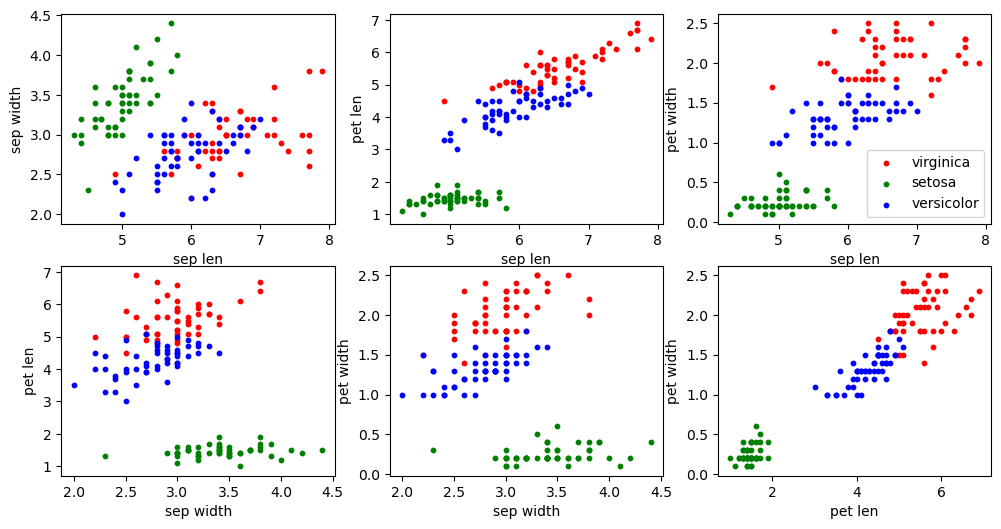

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
colors = ['red', 'green', 'blue']
species = ['virginica', 'setosa', 'versicolor']
features = ['sep len', 'sep width', 'pet len', 'pet width']
feat_combo = list(combinations(np.arange(4), 2))

for i, ax in enumerate(axes.flatten()):
    for spec, color in zip(species, colors):
        x_idx, y_idx = feat_combo[i]
        ax.scatter(irisD[spec][:,x_idx], irisD[spec][:,y_idx], color=color, label=spec, s= 10)
        ax.set_xlabel(features[x_idx])
        ax.set_ylabel(features[y_idx])
    if i==2:
        ax.legend(loc='best', scatterpoints=1)
plt.show()

Without any data transformation, it seems hopeful that the 3 species can be separated quite well. Even when we are just considering each 2 features *in isolation* like we are doing in the plot, for some combinations of features one can imagine drawing circles around each color that isolate each species almost perfectly. Therefore, considering all 4 features in tandem, we should be able to do even better!

As good statisticians, we should recall from [Chapter 4.6](./056-least_squares_data.ipynb) that our goal is not to perfectly fit the data through a model trained on all the data points, but to simulate performance on data yet-to-be-seen. In other words, we should perform a train-test split. For our purposes, let us do a 80-20 split, using 40 samples per species for training and leaving 10 samples for evaluating the performance of the model.

In [4]:
keys = list(irisD.keys())
values = list(irisD.values())

# Subsampling the full dataset dictionary with python list comprehension
irisD_train = {key: value[:40] for key,value in zip(keys, values)}
irisD_test = {key: value[40:] for key,value in zip(keys, values)}
print("Train set size per class:", np.shape(irisD_train['virginica']))
print("Test set size per class:", np.shape(irisD_test['virginica']))

Train set size per class: (40, 4)
Test set size per class: (10, 4)


## Posing Classification as a Least-Squares Problem

At a surface level, classification bears some differences to the regression set-up we've seen in the last few chapters. For one, the *outcome* or *response variable* $y$ in classification is categorical, for example the species of Iris flower, whereas in regression they are numerical and generally continuous. Also, whereas geometrically regression is "fitting a curve", it is not so clear what "curve" we are fitting in classification.

Since our goal is to best predict (read: fit) the class, an immediate idea is to cast the categorical labels into numbers (e.g. integer indices $0,1,2$), and then do regression on numerical labels. To transform back to a final categorical prediction, we can do something like round, then output the variable associated with the integer.

For example, associating $\bm \mathrm{virginica} & \mathrm{setosa} & \mathrm{versicolor} \em$ with $\bm 0 & 1 & 2 \em$, fitting $\bold x = \bm \mathrm{sep\;len} & \mathrm{sep\;width} & \mathrm{pet\;len} & \mathrm{pet\;width} \em^\top \in \R^4$ to $\bold y \in [0,2]$ becomes a regression problem, on which we can apply linear least-squares:
$$
\bold y = \boldsymbol \beta^\top \bold x + c = \bm \boldsymbol \beta \\ c \em^\top \bm \bold x \\ 1 \em,
$$
recalling that accounting for the constant offset $c$ amounts to augmenting our 4 features with an additional feature that is always $1$.

Let's try it out. 

In [5]:
print("Step 1: cast class label to numerical vector")
print("virginica->0, setosa->1, versicolor->2")

nsamples = np.shape(irisD_train['virginica'])[0]
Ys = np.hstack([i*np.ones(nsamples) for i in range(3)])
print("Y shape:",np.shape(Ys))
print(f"Y_1={Ys[0]}, Y_41={Ys[40]}, Y_81={Ys[80]}")

print("\nStep 2: create data matrix and augment with 1")
Xs = np.vstack([data for data in list(irisD_train.values())])
Xs = np.hstack([Xs, np.ones((nsamples*3,1))])
print("X shape:",np.shape(Xs))
print("An (augmented) sample x:", Xs[0])

print("\nStep 3: compute least-squares solution [beta,c]")
# we only care about the actual least-squares solutions (first value)
ls_sol, res, rank, svals = npl.lstsq(Xs, Ys, rcond=None)
print("Least squares solutions [beta, c]:", ls_sol)

Step 1: cast class label to numerical vector
virginica->0, setosa->1, versicolor->2
Y shape: (120,)
Y_1=0.0, Y_41=1.0, Y_81=2.0

Step 2: create data matrix and augment with 1
X shape: (120, 5)
An (augmented) sample x: [6.3 3.3 6.  2.5 1. ]

Step 3: compute least-squares solution [beta,c]
Least squares solutions [beta, c]: [ 0.17683728 -0.75244344 -0.03464528 -0.63248564  3.14923145]


With the least-squares solution in hand, we now need to construct the functions to both convert the numerical predictions back to a categorical label as well as a function to evaluate accuracy.

In [6]:
print("predict() function: given data and least-squares sol, output label")
def predict(X, beta):
    Y_pred = X @ beta
    Y_pred = np.round(Y_pred).astype('int')
    return Y_pred

print("\naccuracy() function: given predictions and true labels, output accuracy")
def accuracy(Y_pred, Y_true):
    Y_pred = Y_pred.astype('int')
    Y_true = Y_true.astype('int')
    return np.average(Y_pred == Y_true)

print("\nNow let's print the accuracy on the TRAINING set (ideally should be high)")
Y_pred = predict(Xs, ls_sol)
print("Training accuracy:", accuracy(Y_pred, Ys))

print("\nAnd now on the TEST set")
nsamples = np.shape(irisD_test['virginica'])[0]
Xs_test = np.vstack([data for data in list(irisD_test.values())])
Xs_test = np.hstack([Xs_test, np.ones((nsamples*3,1))])
Ys_test = np.hstack([i*np.ones(nsamples) for i in range(3)])

Y_pred_test = predict(Xs_test, ls_sol)
print("Test accuracy:", accuracy(Y_pred_test, Ys_test))

predict() function: given data and least-squares sol, output label

accuracy() function: given predictions and true labels, output accuracy

Now let's print the accuracy on the TRAINING set (ideally should be high)
Training accuracy: 0.4

And now on the TEST set
Test accuracy: 0.5


Hmmm...that's not ideal. On one hand, it seems this classifier is marginally better than guessing at random, which would net an accuracy of around 1/3, but it is a far cry from near-perfect. What's going on? Well, to sanity check what we just did, let's plot a scatter plot of each individual feature against the label.

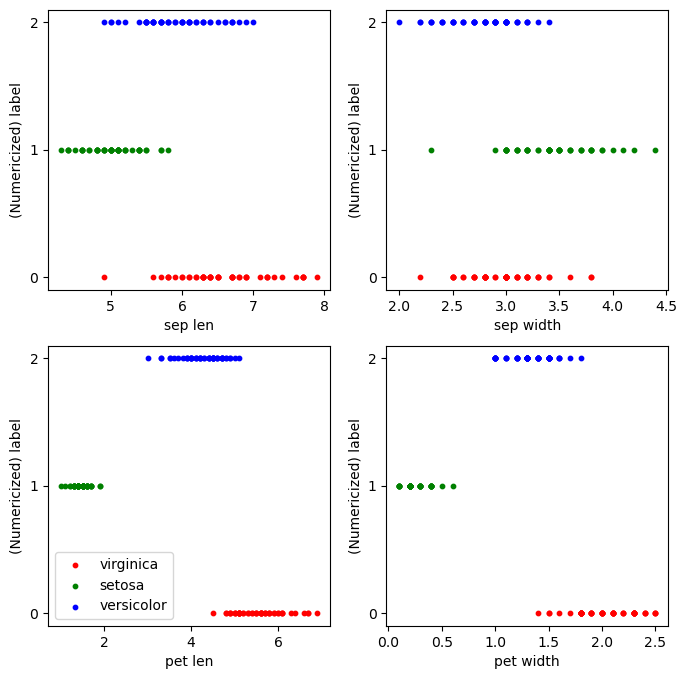

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

for i, ax in enumerate(axes.flatten()):
    for label, (spec, color) in enumerate(zip(species, colors)):
        ax.scatter(irisD[spec][:,i], label*np.ones_like(irisD[spec][:,i]), color=color, label=spec, s= 10)
        ax.set_xlabel(features[i])
        ax.set_yticks([0,1,2])
        ax.set_ylabel('(Numericized) label')
    if i==2:
        ax.legend(loc='best', scatterpoints=1)
plt.show()

While looking at one feature at a time is certainly more restrictive than fitting over all of them at once, this perhaps hints at the problem. If we were to try to fit a line of best fit on any of these graphs, we would be hard-pressed to find a line that simultaneously fits each species well. So, even though in the earlier scatter plots we could easily draw circles delineating accurate boundaries by hand, we may not be able to find a line that *simultaneously* fits all three species.

## One-versus-rest Least-squares Classification

So what now? Maybe trying to fit all three species with one line is the wrong way to apply least-squares. A strictly easier problem is to distinguish whether a given sample is, e.g., "virginica" or "not virginica". To visualize this, in the above scatter plots, if we had merged the blue and green dots to be $1$ and kept red ("virginica") at $0$, then some of these plots look more linearly fittable.

Of course, we still need to classify the other species. Therefore, we can train a binary classifier for each species: "virginica" vs "not virginica", "setosa" vs "not setosa", and "versicolor" vs "not versicolor". For a given measurement $\bold x \in \R^4$, we then run it through each classifier. If we get exactly one classifier identify positively and the others negatively, then in principle we can be confident that this sample will be classified correctly. In the case of multiple positive IDs, we can break ties randomly. This is a version of [one-versus-rest classification](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/).

### Virginica classifier

In [8]:
print("Form new numerical Y vector; we can use same X matrix from earlier")
Ys_vir = np.zeros(120)
Ys_vir[:40]+=1
print(Ys_vir)

ls_sol_vir, _, _, _ = npl.lstsq(Xs, Ys_vir, rcond=None)
print("Virginica least squares solution [beta, c]:", ls_sol_vir)

Y_pred_vir = predict(Xs, ls_sol_vir)
print("Training accuracy:", accuracy(Y_pred_vir, Ys_vir))

Form new numerical Y vector; we can use same X matrix from earlier
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Virginica least squares solution [beta, c]: [-0.10752895  0.24894277  0.10660433  0.38023175 -0.6537962 ]
Training accuracy: 0.9083333333333333


This is a much more encouraging prediction accuracy! Granted, this is solely for predicting "virginica". Let's repeat this for the other two species.

### Setosa classifier

In [9]:
print("Form new numerical Y vector")
Ys_set = np.zeros(120)
Ys_set[40:80]+=1
print(Ys_set)

ls_sol_set, _, _, _ = npl.lstsq(Xs, Ys_set, rcond=None)
print("Setosa least squares solution [beta, c]:", ls_sol_set)

Y_pred_set = predict(Xs, ls_sol_set)
print("Training accuracy:", accuracy(Y_pred_set, Ys_set))

Form new numerical Y vector
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Setosa least squares solution [beta, c]: [ 0.03822063  0.25455789 -0.17856338 -0.12797785  0.15836094]
Training accuracy: 1.0


### Versicolor classifier

In [10]:
print("Form new numerical Y vector")
Ys_ver = np.zeros(120)
Ys_ver[80:]+=1
print(Ys_ver)

ls_sol_ver, _, _, _ = npl.lstsq(Xs, Ys_ver, rcond=None)
print("Setosa least squares solution [beta, c]:", ls_sol_ver)

Y_pred_ver = predict(Xs, ls_sol_ver)
print("Training accuracy:", accuracy(Y_pred_ver, Ys_ver))

Form new numerical Y vector
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Setosa least squares solution [beta, c]: [ 0.06930832 -0.50350067  0.07195905 -0.2522539   1.49543526]
Training accuracy: 0.7416666666666667


### Combining classifiers

We now write the code to combine these three individual classifiers in the way we described earlier.

In [11]:
def one_vs_rest_predict(X, beta1, beta2, beta3):
    pred_mat = np.vstack(1*[predict(X, beta1), 2*predict(X, beta2), 3*predict(X, beta3)])
    
    pred = np.zeros(pred_mat.shape[1])
    for i in range(pred_mat.shape[1]):
        idx = np.where(pred_mat[:,i] > 0)[0]
        if len(idx) == 1:
            # if no disagreement; output the non-zero label
            pred[i] = np.amax(pred_mat[:,i])
        elif len(idx) == 0:
            # if entry has no positive label, choose randomly across all labels
            pred[i] = np.random.choice([1,2,3])
        elif len(idx) > 1:
            # if more than one classifier marks positive, break tie randomly
            pred[i] = np.random.choice(pred_mat[:,i][idx])
        
    return pred-1

Y_pred_1vsRes = one_vs_rest_predict(Xs, ls_sol_vir, ls_sol_set, ls_sol_ver)
Y_pred_1vsRes_test = one_vs_rest_predict(Xs_test, ls_sol_vir, ls_sol_set, ls_sol_ver)
print("Training accuracy:", accuracy(Y_pred_1vsRes, Ys))
print("Test accuracy:", accuracy(Y_pred_1vsRes_test, Ys_test))

Training accuracy: 0.8416666666666667
Test accuracy: 0.8333333333333334


Since we happen to break ties here with randomness, the accuracy does fluctuate between different runs, but it does seem our smarter One-vs-Rest least-squares classifier does perform much better! We could have certainly come up with smarter tie-breaking schemes that are better than uniform random (e.g. by leveraging [k-means from Chapter 3.6-7](../02_Ch_3_Inner_Products_and_Norms/045-handwritten_digits.ipynb)), which could bump up the accuracy a bit more.

In [12]:
for i in range(5):
    Y_pred_1vsRes = one_vs_rest_predict(Xs, ls_sol_vir, ls_sol_set, ls_sol_ver)
    Y_pred_1vsRes_test = one_vs_rest_predict(Xs_test, ls_sol_vir, ls_sol_set, ls_sol_ver)
    print("Training accuracy:", accuracy(Y_pred_1vsRes, Ys))
    print("Test accuracy:", accuracy(Y_pred_1vsRes_test, Ys_test))

Training accuracy: 0.825
Test accuracy: 0.9
Training accuracy: 0.775
Test accuracy: 0.8
Training accuracy: 0.8083333333333333
Test accuracy: 0.8666666666666667
Training accuracy: 0.7916666666666666
Test accuracy: 0.8333333333333334
Training accuracy: 0.8
Test accuracy: 0.8666666666666667


### The Confusion Matrix

Just as in the [handwritten digit classification case study](../02_Ch_3_Inner_Products_and_Norms/045-handwritten_digits.ipynb)), we can get a finer-grained understanding of which classes our classifier had trouble differentiating through the confusion matrix. Recall that the entries of the confusion matrix $\bold C = [c_{ij}]$ represent the number of times our classifier predicted label $i$ when the true label was $j$, such that the diagonal elements $c_{ii}$ represent the number of times label $i$ was predicted correctly.

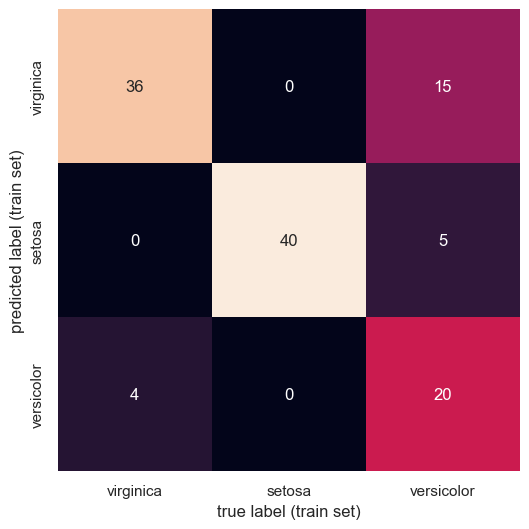

In [13]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

species = ['virginica', 'setosa', 'versicolor']
conf_train = confusion_matrix(Ys, Y_pred_1vsRes, labels = np.array([0,1,2])) 
sns.heatmap(conf_train.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species,
            yticklabels=species)
plt.xlabel('true label (train set)')
plt.ylabel('predicted label (train set)')
plt.show()

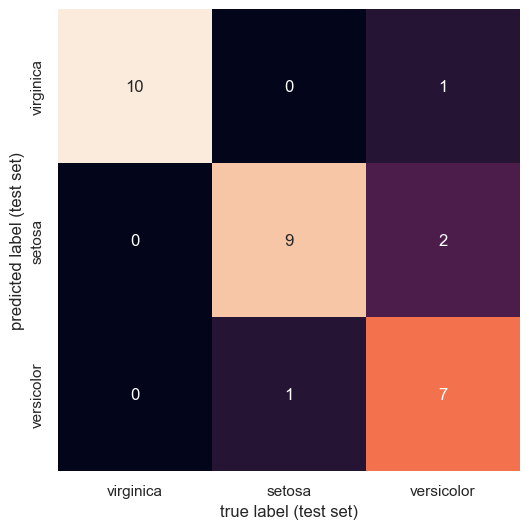

In [14]:
conf_test = confusion_matrix(Ys_test, Y_pred_1vsRes_test, labels = np.array([0,1,2])) 
sns.heatmap(conf_test.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species,
            yticklabels=species)
plt.xlabel('true label (test set)')
plt.ylabel('predicted label (test set)')
plt.show()

From the confusion matrix, we can glean that "versicolor" is hard for our classifier to get right, often predicting both other species instead of it. The other two species seem to be rather well-lassified, with minimal errors.